## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [2]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/your own folder/

## Import library

In [3]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50


## 設定超參數

In [4]:
SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 1e-3
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0

PRUNE_PATH = './model_prune.pth' # Change to your own folder !!!
PRUNE_FINETUNE_PATH = './model_prune_finetune.pth' # Change to your own folder !!!


#### 檢查是否檢查是否可使用GPU

In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 載入剪枝後的網路與權重

In [7]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  cfg = checkpoint['cfg']
  model = ResNet50(num_classes=10,cfg=cfg)
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


## 設定 Optimizer & CrossEntropy Loss

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 定義訓練跟測試函數

In [9]:
from tqdm import tqdm
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!

def train(epoch):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0

    for data, target in tqdm(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]

        # save training loss & acc 
        train_loss += loss.item() * data.size(0)
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        train_total += target.size(0)

        # if batch_idx % LOG_INTERVAL == 0:
        #     print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.data.item()))

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0.0
    correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            test_total += target.size(0)

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
        test_acc = 100 * correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        return correct / float(len(test_loader.dataset))


best_prec1 = 0.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本之十分之一
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重
    if(prec1 > best_prec1):
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
            'cfg': cfg
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')


100%|██████████| 500/500 [00:24<00:00, 20.09it/s]


Epoch [1/20] Train Loss: 0.6207 | Train Acc: 79.26%


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]



Test set: Average loss: 0.4903, Accuracy: 8379/10000 (83.8%)



100%|██████████| 500/500 [00:24<00:00, 20.58it/s]


Epoch [2/20] Train Loss: 0.4173 | Train Acc: 86.00%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]



Test set: Average loss: 0.4927, Accuracy: 8398/10000 (84.0%)



100%|██████████| 500/500 [00:24<00:00, 20.46it/s]


Epoch [3/20] Train Loss: 0.3811 | Train Acc: 86.88%


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]



Test set: Average loss: 0.4622, Accuracy: 8463/10000 (84.6%)



100%|██████████| 500/500 [00:24<00:00, 20.31it/s]


Epoch [4/20] Train Loss: 0.3557 | Train Acc: 87.89%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.4388, Accuracy: 8567/10000 (85.7%)



100%|██████████| 500/500 [00:24<00:00, 20.43it/s]


Epoch [5/20] Train Loss: 0.3337 | Train Acc: 88.69%


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]



Test set: Average loss: 0.4149, Accuracy: 8671/10000 (86.7%)



100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch [6/20] Train Loss: 0.3237 | Train Acc: 88.96%


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]



Test set: Average loss: 0.4383, Accuracy: 8625/10000 (86.2%)



100%|██████████| 500/500 [00:24<00:00, 20.37it/s]


Epoch [7/20] Train Loss: 0.3098 | Train Acc: 89.38%


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]



Test set: Average loss: 0.4454, Accuracy: 8557/10000 (85.6%)



100%|██████████| 500/500 [00:24<00:00, 20.29it/s]


Epoch [8/20] Train Loss: 0.2995 | Train Acc: 89.73%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.4516, Accuracy: 8545/10000 (85.4%)



100%|██████████| 500/500 [00:24<00:00, 20.38it/s]


Epoch [9/20] Train Loss: 0.2883 | Train Acc: 90.10%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.4215, Accuracy: 8695/10000 (86.9%)



100%|██████████| 500/500 [00:24<00:00, 20.24it/s]


Epoch [10/20] Train Loss: 0.2752 | Train Acc: 90.50%


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]



Test set: Average loss: 0.4235, Accuracy: 8673/10000 (86.7%)



100%|██████████| 500/500 [00:24<00:00, 20.19it/s]


Epoch [11/20] Train Loss: 0.1921 | Train Acc: 93.57%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.3295, Accuracy: 8990/10000 (89.9%)



100%|██████████| 500/500 [00:24<00:00, 20.17it/s]


Epoch [12/20] Train Loss: 0.1678 | Train Acc: 94.31%


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]



Test set: Average loss: 0.3366, Accuracy: 9007/10000 (90.1%)



100%|██████████| 500/500 [00:24<00:00, 20.30it/s]


Epoch [13/20] Train Loss: 0.1526 | Train Acc: 94.80%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.3422, Accuracy: 9000/10000 (90.0%)



100%|██████████| 500/500 [00:24<00:00, 20.19it/s]


Epoch [14/20] Train Loss: 0.1477 | Train Acc: 94.99%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]



Test set: Average loss: 0.3505, Accuracy: 9015/10000 (90.2%)



100%|██████████| 500/500 [00:24<00:00, 20.35it/s]


Epoch [15/20] Train Loss: 0.1449 | Train Acc: 94.99%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]



Test set: Average loss: 0.3384, Accuracy: 9043/10000 (90.4%)



100%|██████████| 500/500 [00:24<00:00, 20.37it/s]


Epoch [16/20] Train Loss: 0.1334 | Train Acc: 95.44%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.3400, Accuracy: 9044/10000 (90.4%)



100%|██████████| 500/500 [00:24<00:00, 20.24it/s]


Epoch [17/20] Train Loss: 0.1287 | Train Acc: 95.61%


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]



Test set: Average loss: 0.3375, Accuracy: 9054/10000 (90.5%)



100%|██████████| 500/500 [00:24<00:00, 20.36it/s]


Epoch [18/20] Train Loss: 0.1280 | Train Acc: 95.61%


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]



Test set: Average loss: 0.3385, Accuracy: 9052/10000 (90.5%)



100%|██████████| 500/500 [00:24<00:00, 20.34it/s]


Epoch [19/20] Train Loss: 0.1313 | Train Acc: 95.47%


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]



Test set: Average loss: 0.3391, Accuracy: 9039/10000 (90.4%)



100%|██████████| 500/500 [00:24<00:00, 20.36it/s]


Epoch [20/20] Train Loss: 0.1294 | Train Acc: 95.63%


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Test set: Average loss: 0.3426, Accuracy: 9057/10000 (90.6%)


 TRAIN PRUNED MODEL DONE!


## 繪製Fine-tuning結果圖


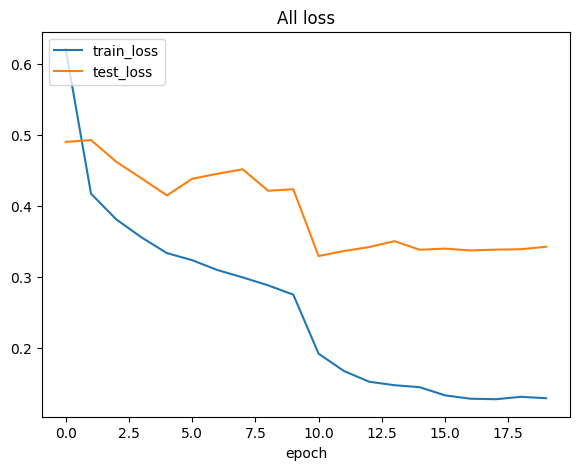

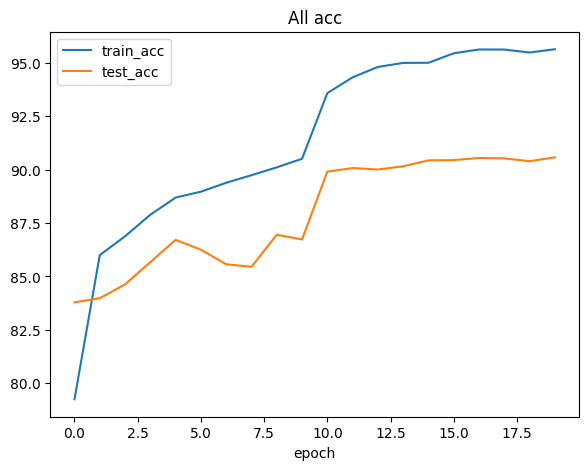

In [10]:
#繪製Fine-tuning結果圖
import matplotlib.pyplot as plt
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_accuracies)
    ax1.plot(test_accuracies)

    ax1.legend(['train_acc', 'test_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_losses)
    ax1.plot(test_losses)

    ax1.legend(['train_loss', 'test_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()

## FLOPs & Parameters

In [11]:
!pip install thop
!pip install torchsummary


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from thop import profile
from torchsummary import summary

##### 使用 thop 計算 FLOPs 和參數數量 #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 130318480.0
Params: 3736356.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]           